### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy.stats import skew
import nbimporter

from Functions import calculate_descriptives


# Master Query from Database

In [2]:
# connect to DB and query data needed for modeling

In [3]:
# split data

# EDA on Training Data

### Load in Dataframes

In [4]:
documents_table= pd.read_csv('documents_table.csv')
documents_table.head()
documents_table.dtypes

doc_id                              int64
doc_type                           object
year                                int64
drug                               object
drug administration error           int64
                                    ...  
eosinophil percentage decreased     int64
supraventricular tachycardia        int64
radiation skin injury               int64
hypokalaemia                        int64
all_reactions                      object
Length: 929, dtype: object

### Investigate most common drugs, referenced in historical documents

#### insights
* need to remove some values like air, body, oxygen

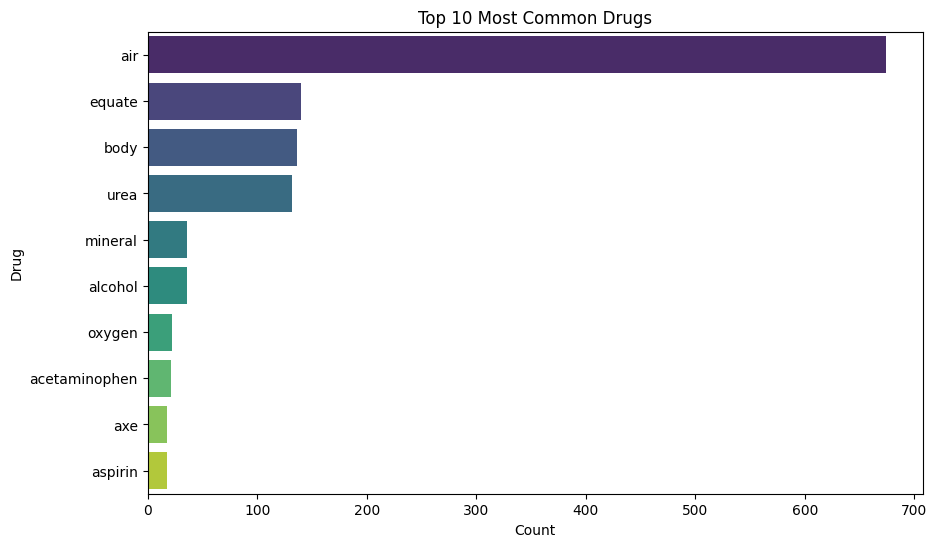

In [5]:
top_drugs = documents_table['drug'].value_counts().head(10)
top_drugs = top_drugs.reset_index().rename(columns={'index': 'drug', 'drug': 'count'})

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='drug', data=top_drugs, palette='viridis')
plt.title('Top 10 Most Common Drugs')
plt.xlabel('Count')
plt.ylabel('Drug')
plt.show()

### Investigate most common reactions, referenced in historical documents

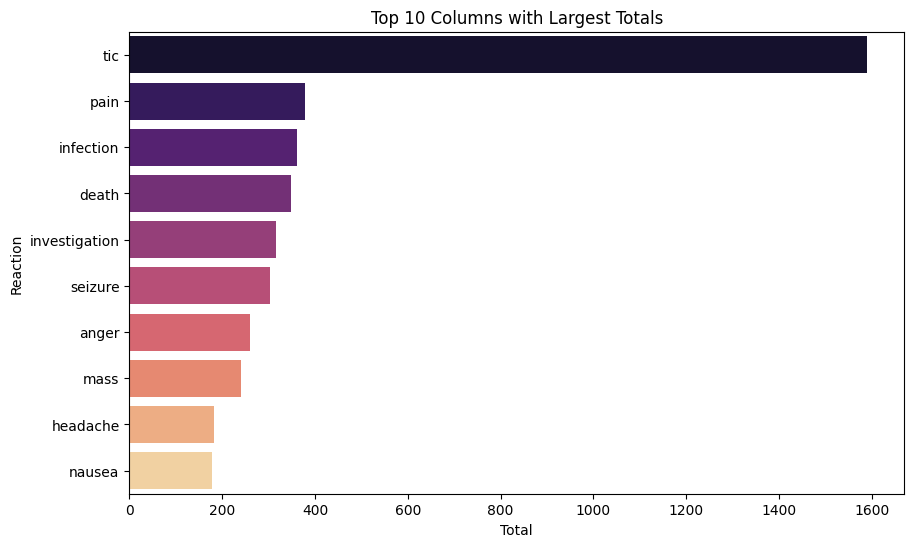

In [6]:
reaction_cols = documents_table.drop(columns=['doc_id','doc_type', 'year', 'drug', 'all_reactions']).sum()
top_reactions = reaction_cols.nlargest(10)


# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_reactions.values, y=top_reactions.index, palette='magma')
plt.title('Top 10 Columns with Largest Totals')
plt.xlabel('Total')
plt.ylabel('Reaction')
plt.show()

In [7]:
documents_table.head()

,doc_id,doc_type,year,drug,drug administration error,overdose,drug hypersensitivity,rhinorrhoea,unevaluable event,malaise,...,asphyxia,lymphocyte percentage decreased,blood pressure diastolic increased,aspiration,neutrophil percentage increased,eosinophil percentage decreased,supraventricular tachycardia,radiation skin injury,hypokalaemia,all_reactions
0,1,pr,2006,equate,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['tic']
1,2,pr,2006,equate,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"['seizure', 'tic']"
2,3,talk,1991,axe,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']
3,3,talk,1991,air,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']
4,3,talk,1991,air,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,['investigation']


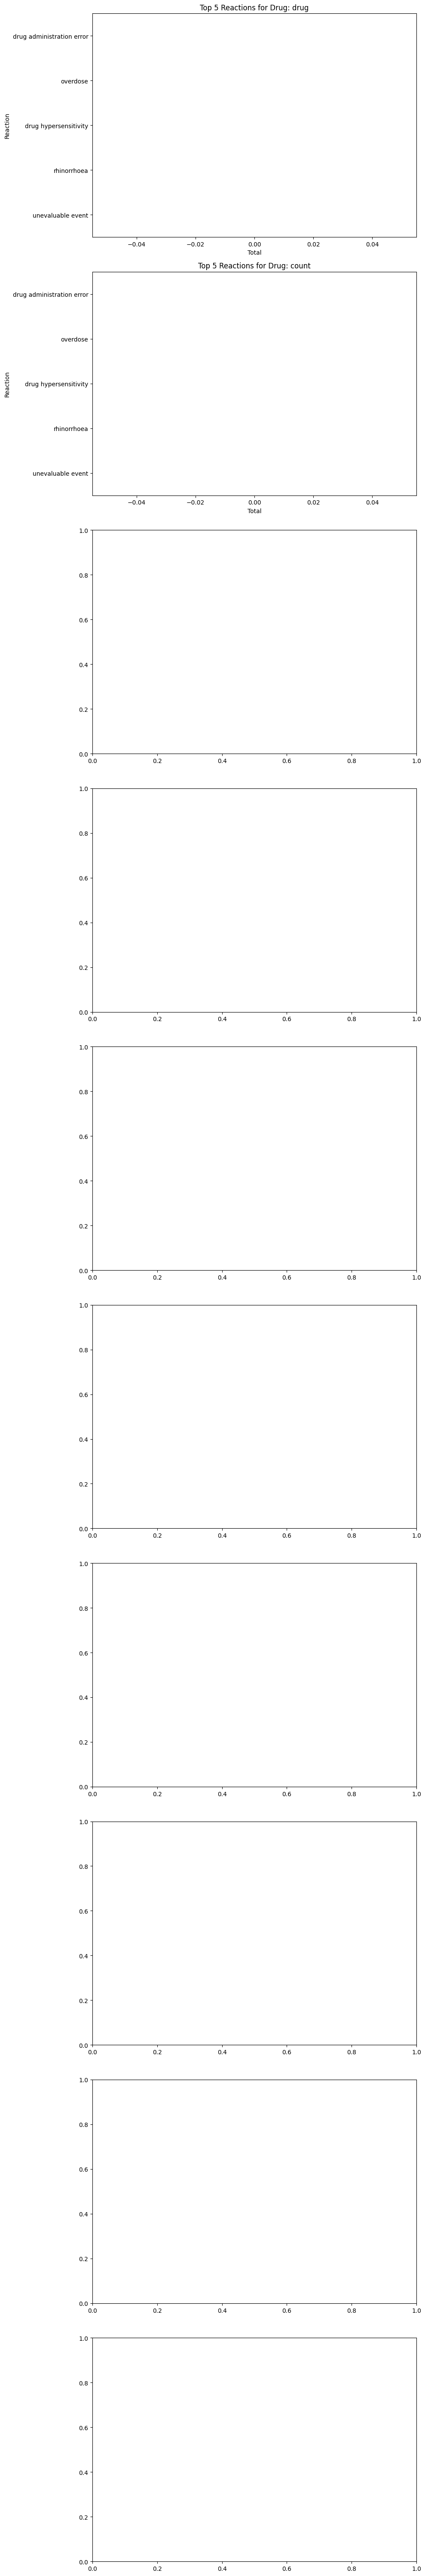

In [8]:

# Step 2: Filter documents_table to include only top 5 drugs
filtered_table = documents_table[documents_table['drug'].isin(top_drugs)]

# Step 3: Calculate top 5 reactions for each top drug
top_reactions_per_drug = {}
for drug in top_drugs:
    drug_data = filtered_table[filtered_table['drug'] == drug]
    reaction_counts = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug', 'all_reactions']).sum()
    top_reactions = reaction_counts.nlargest(5).index.tolist()
    top_reactions_per_drug[drug] = top_reactions

# Step 4: Create subplots for each drug
num_drugs = len(top_drugs)
fig, axes = plt.subplots(num_drugs, 1, figsize=(10, 6*num_drugs))

for i, drug in enumerate(top_drugs):
    ax = axes[i]
    drug_data = filtered_table[filtered_table['drug'] == drug]
    reaction_counts = drug_data.drop(columns=['doc_id', 'doc_type', 'year', 'drug','all_reactions']).sum()
    top_reactions = reaction_counts.nlargest(5)
    
    # Plotting
    sns.barplot(x=top_reactions.values, y=top_reactions.index, ax=ax, palette='magma')
    ax.set_title(f'Top 5 Reactions for Drug: {drug}')
    ax.set_xlabel('Total')
    ax.set_ylabel('Reaction')

plt.tight_layout()
plt.show()

# Reactions Table

## Outcome Variable

In [9]:
reactions = pd.read_csv('DataLibrary/reactions_table.csv')
reactions.head()

,patient_reaction_id,event_id,version_medDRA,outcome,reaction_processed
0,1,1,NaN,NaN,"['drug', 'administration', 'error', 'drug admi..."
1,2,1,NaN,NaN,['overdose']
2,3,5,17.0,Unknown,"['drug', 'hypersensitivity', 'drug hypersensit..."
3,4,6,17.0,Unknown,"['drug', 'hypersensitivity', 'drug hypersensit..."
4,5,8,18.1,Unknown,['rhinorrhoea']


#### Graph

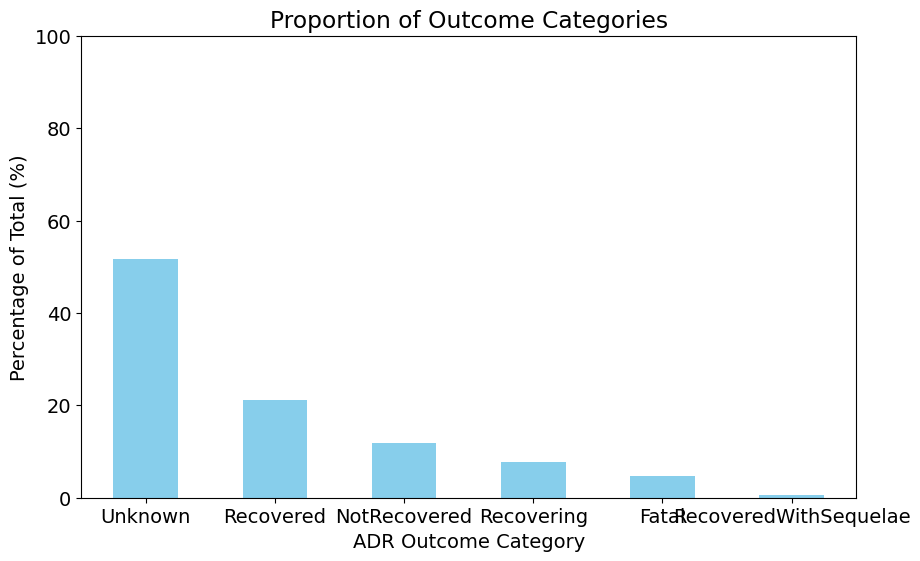

In [10]:
# Count the frequency of each category
category_counts = reactions['outcome'].value_counts()

# Calculate the percentages
total = len(reactions)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [11]:
print(f"Frequency:", reactions['outcome'].value_counts()), print(f"Proportion:", reactions['outcome'].value_counts(normalize = True))

Frequency: Unknown                  1144
Recovered                 469
NotRecovered              261
Recovering                173
Fatal                     103
RecoveredWithSequelae      12
Name: outcome, dtype: int64
Proportion: Unknown                  0.529140
Recovered                0.216929
NotRecovered             0.120722
Recovering               0.080019
Fatal                    0.047641
RecoveredWithSequelae    0.005550
Name: outcome, dtype: float64


(None, None)

### MeDRA Term Versions

#### Graph

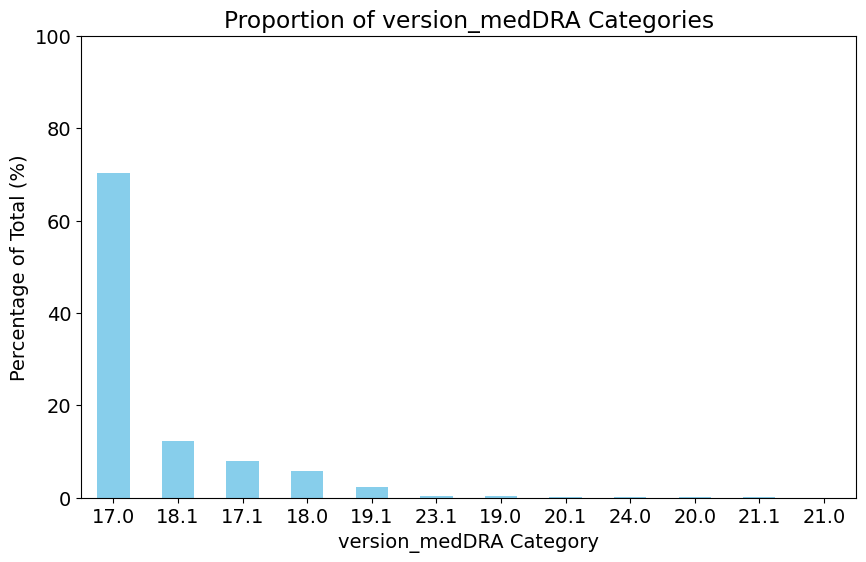

In [12]:
# Count the frequency of each category
category_counts = reactions['version_medDRA'].value_counts()

# Calculate the percentages
total = len(reactions)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of version_medDRA Categories')
plt.xlabel('version_medDRA Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [13]:
print(f"Frequency:", reactions['version_medDRA'].value_counts()), 
print(f"Proportion:", reactions['version_medDRA'].value_counts(normalize = True))

Frequency: 17.0    1556
18.1     274
17.1     176
18.0     129
19.1      49
23.1       8
19.0       6
20.1       4
24.0       3
20.0       3
21.1       2
21.0       1
Name: version_medDRA, dtype: int64
Proportion: 17.0    0.703754
18.1    0.123926
17.1    0.079602
18.0    0.058345
19.1    0.022162
23.1    0.003618
19.0    0.002714
20.1    0.001809
24.0    0.001357
20.0    0.001357
21.1    0.000905
21.0    0.000452
Name: version_medDRA, dtype: float64


### Processed Reaction Terms

In [14]:
# descriptive text stat function

# Events Table

In [31]:
events.dtypes

event_id                        int64
safetyreportid                 object
event_date                     object
serious                         int64
expedited                       int64
report_source                   int64
safetyreportversion           float64
country                        object
age                           float64
sex                             int64
company_name                  float64
event_graph            datetime64[ns]
dtype: object

In [32]:
# Update to query 
events = pd.read_csv('DataLibrary/events_table.csv')
events.head()

,event_id,safetyreportid,event_date,serious,expedited,report_source,safetyreportversion,country,age,sex,company_name
0,1,5801206-7,2009-01-09,1,1,3,NaN,cn,26.0,1,NaN
1,5,10003304,2014-12-12,0,2,1,2.0,us,NaN,2,NaN
2,6,10003305,2014-10-02,0,2,1,1.0,us,48.0,2,NaN
3,8,10003307,2015-11-25,0,2,1,3.0,us,65.0,2,NaN
4,9,10003308,2015-11-25,0,2,1,3.0,us,59.0,2,NaN


In [16]:
events.shape

(757, 11)

### Age

#### Graph

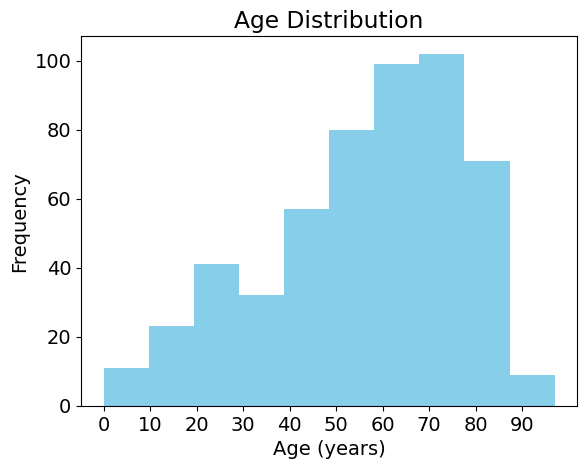

In [17]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Age
plt.hist(events['age'].astype('float'), color = 'skyblue')
ticks = np.arange(0, 100, 10)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

#### Descriptives

In [18]:
events_age_descriptives = calculate_descriptives(events['age'])
print(events_age_descriptives)

+------------------------+----------+
| Statistic              |    Value |
+========================+==========+
| Median (Md)            |  60      |
+------------------------+----------+
| Mean (x-bar)           |  56.1878 |
+------------------------+----------+
| Standard Deviation (s) |  20.7576 |
+------------------------+----------+
| Variance (s2)          | 430.879  |
+------------------------+----------+
| Skewness               | nan      |
+------------------------+----------+
| First Quartile (Q1)    |  45      |
+------------------------+----------+
| Third Quartile (Q3)    |  71      |
+------------------------+----------+
None


### Report Dates

In [35]:
events['event_date'] = pd.to_datetime(events['event_date'])

events_year = pd.DataFrame()
events_year['year'] = events['event_date'].dt.year

event_year_descriptives = calculate_descriptives(events_year['year'])

+------------------------+-------------+
| Statistic              |       Value |
+========================+=============+
| Median (Md)            | 2014        |
+------------------------+-------------+
| Mean (x-bar)           | 2014.33     |
+------------------------+-------------+
| Standard Deviation (s) |    0.777021 |
+------------------------+-------------+
| Variance (s2)          |    0.603762 |
+------------------------+-------------+
| Skewness               |    3.74427  |
+------------------------+-------------+
| First Quartile (Q1)    | 2014        |
+------------------------+-------------+
| Third Quartile (Q3)    | 2015        |
+------------------------+-------------+


#### Graph

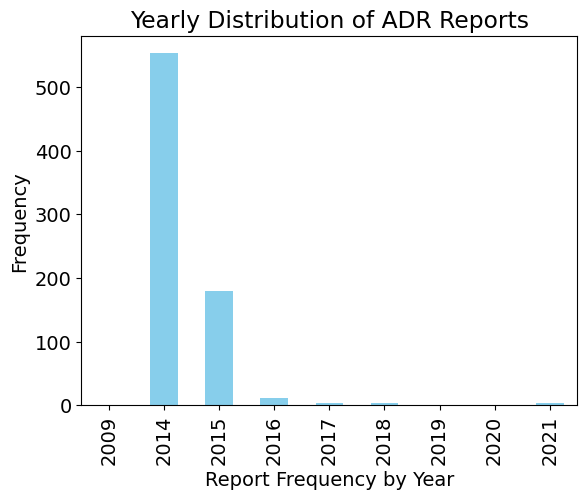

In [19]:
# Text size
plt.rcParams.update({'font.size': 14})

# Update variable type
events['event_graph'] = events['event_date'].astype("datetime64[ns]")

# Distribution of Reports
events['event_graph'].groupby([events["event_graph"].dt.year]).count().plot(kind="bar", color = "skyblue")
#ticks = np.arange(1968, 2025, 1)  # Customize this range as needed
#plt.xticks(ticks)
plt.xlabel('Report Frequency by Year')
plt.ylabel('Frequency')
plt.title('Yearly Distribution of ADR Reports')
plt.show()

#### Descriptives

### Seriousness of Report

#### Graph

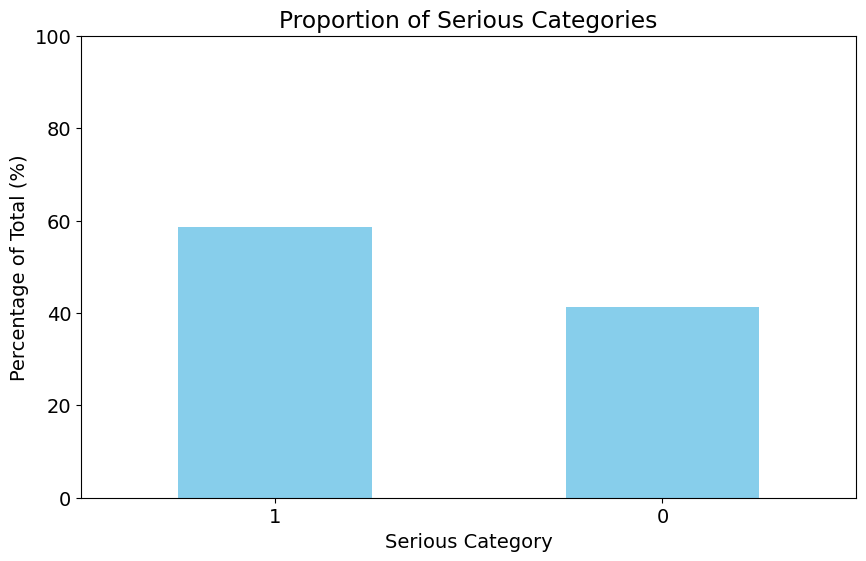

In [20]:
# Count the frequency of each category
category_counts = events['serious'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Serious Categories')
plt.xlabel('Serious Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

#### Descriptives

In [21]:
print(f"Frequency:", events['serious'].value_counts()), 
print(f"Proportion:", events['serious'].value_counts(normalize = True))

Frequency: 1    444
0    313
Name: serious, dtype: int64
Proportion: 1    0.586526
0    0.413474
Name: serious, dtype: float64


### Expedited Criteria Status

#### Graph

In [22]:
# Count the frequency of each category
category_counts = events['fulfillexpeditecriteria'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Expedited Categories')
plt.xlabel('Expedited Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

KeyError: 'fulfillexpeditecriteria'

#### Descriptives

In [ ]:
print(f"Frequency:", events['fulfillexpeditecriteria'].value_counts()), 
print(f"Proportion:", events['fulfillexpeditecriteria'].value_counts(normalize = True))

### Report Source

#### Graph

In [ ]:
# Count the frequency of each category
category_counts = events['report_source'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Report Source Categories')
plt.xlabel('Source Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,2,3]
#labels = ['Doc', 'Pharm', 'Other']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", events['report_source'].value_counts()), 
print(f"Proportion:", events['report_source'].value_counts(normalize = True))

### Company

#### Descriptives

In [ ]:
print(f"Frequency:", events['company_name'].value_counts()), 
print(f"Proportion:", events['company_name'].value_counts(normalize = True))

### Country 

#### Graph

In [ ]:
# Count the frequency of each category
category_counts = events['country'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Country Categories')
plt.xlabel('Country Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,2,3]
#labels = ['Doc', 'Pharm', 'Other']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", events['country'].value_counts()), 
print(f"Proportion:", events['country'].value_counts(normalize = True))

### Sex

#### Graph

In [ ]:
# Count the frequency of each category
category_counts = events['sex'].value_counts()

# Calculate the percentages
total = len(events)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Sex Categories')
plt.xlabel('Sex Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,2,3]
#labels = ['Doc', 'Pharm', 'Other']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", events['sex'].value_counts()), 
print(f"Proportion:", events['sex'].value_counts(normalize = True))

# Labels Table

In [ ]:
# Update to query 
labels = pd.read_csv('DataLibrary/labels_table.csv')
labels.head()

### Label Dates

#### Graph

In [ ]:
# Text size
plt.rcParams.update({'font.size': 14})

# Update variable type
labels['label_graph'] = labels['label_date'].astype("datetime64[ns]")

# Distribution of Reports
labels['label_date'].groupby([labels['label_graph'].dt.year]).count().plot(kind="bar", color = "skyblue")
#ticks = np.arange(1968, 2025, 1)  # Customize this range as needed
#plt.xticks(ticks)
plt.xlabel('Label Date Frequency by Year')
plt.ylabel('Frequency')
plt.title('Distribution of Label Dates')
plt.show()

#### Descriptives

### Ingredient List

In [ ]:
# descriptive text stat function

### Warnings

In [ ]:
# descriptive text stat function

### Drug Names

In [ ]:
# descriptive text stat function

# Patient Drugs Table

In [27]:
# Update to query 
drugs = pd.read_csv('DataLibrary/drugs_table.csv')
drugs.head()

,patient_drug_id,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_type,rxcui,unii,manufacturers,manu_num,rxcui_num
0,1,1,1,DURAGESIC-100,DRUG ABUSE,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2,5,1,DOXYCYCLINE HYCLATE,NaN,"['DOXYCYCLINE HYCLATE', 'DOXYCYCLINE', 'DOXYCL...","['Mayne Pharma Commercial LLC', 'Actavis Pharm...",['HUMAN PRESCRIPTION DRUG'],"['1653433', '2122343', '1650143', '1652674', '...","['19XTS3T51U', 'N12000U13O', '8ZL07I20SB']","['mayne-pharma-commercial-', 'actavis-pharma',...",31,31
2,3,5,1,TRAMADOL HYDROCHLORIDE,NaN,['TRAMADOL HYDROCHLORIDE'],"['Amneal Pharmaceuticals NY LLC', 'Zydus Pharm...",['HUMAN PRESCRIPTION DRUG'],"['835603', '2395808', '833709', '833711', '833...",['9N7R477WCK'],"['amneal-pharmaceuticals-ny-', 'zydus-pharmace...",18,17
3,4,5,1,OXYCONTIN,NaN,['OXYCODONE HYDROCHLORIDE'],['Purdue Pharma LP'],['HUMAN PRESCRIPTION DRUG'],"['1049504', '1049545', '1049565', '1049576', '...",['C1ENJ2TE6C'],['purdue-pharma-lp'],1,14
4,5,5,1,TALWIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


### Medicinal Product

In [ ]:
# descriptive text stat function

### Manufacturers

In [28]:
num_manu_descriptives = calculate_descriptives(drugs['manu_num'])


+------------------------+------------+
| Statistic              |      Value |
+========================+============+
| Median (Md)            |    1       |
+------------------------+------------+
| Mean (x-bar)           |    7.53213 |
+------------------------+------------+
| Standard Deviation (s) |   40.2818  |
+------------------------+------------+
| Variance (s2)          | 1622.62    |
+------------------------+------------+
| Skewness               |   10.3081  |
+------------------------+------------+
| First Quartile (Q1)    |    0       |
+------------------------+------------+
| Third Quartile (Q3)    |    1       |
+------------------------+------------+


### Unique Ingredient Identifiers

### Drug Characterization

# Prices Table

In [24]:
# Update to query 
prices = pd.read_csv('DataLibrary/prices_table.csv')
prices.head()

,price_id,ndc,unit_price,price_date,generic_brand
0,1,24385005452,0.28255,2022-12-21,1
1,2,70000047501,0.28255,2022-12-21,1
2,3,46122038576,0.78326,2022-12-21,1
3,4,70000036201,0.15365,2022-12-21,1
4,5,70000036202,0.15365,2022-12-21,1


### National Average Cost per Unit

#### Graph

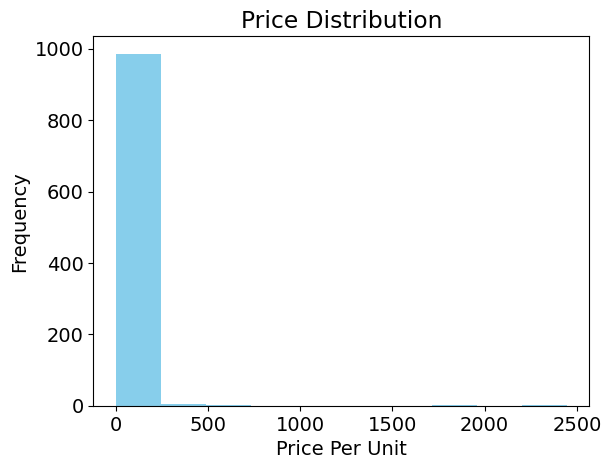

In [25]:
# Text size
plt.rcParams.update({'font.size': 14})

# Distribution of Age
plt.hist(prices['unit_price'].astype('float'), color = 'skyblue')
#ticks = np.arange(0, 100, 10)  # Customize this range as needed
#plt.xticks(ticks)
plt.xlabel('Price Per Unit')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

#### Descriptives

In [26]:
prices_descriptives = calculate_descriptives(prices['unit_price'])


+------------------------+-------------+
| Statistic              |       Value |
+========================+=============+
| Median (Md)            |     0.17494 |
+------------------------+-------------+
| Mean (x-bar)           |    18.5282  |
+------------------------+-------------+
| Standard Deviation (s) |   172.333   |
+------------------------+-------------+
| Variance (s2)          | 29698.6     |
+------------------------+-------------+
| Skewness               |    12.0784  |
+------------------------+-------------+
| First Quartile (Q1)    |     0.0515  |
+------------------------+-------------+
| Third Quartile (Q3)    |     0.64417 |
+------------------------+-------------+


### Effective Price Dates

### Drug Type

#### Graph

In [ ]:
# Count the frequency of each category
category_counts = prices['generic_brand'].value_counts()

# Calculate the percentages
total = len(prices)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Drug Type')
plt.xlabel('Drug Type Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
#nums = [1,0]
#labels = ['Generic', 'Brand']
#plt.legend(nums, labels)
plt.show()

#### Descriptives

In [ ]:
print(f"Frequency:", prices['generic_brand'].value_counts()), 
print(f"Proportion:", prices['generic_brand'].value_counts(normalize = True))

# Manufacturer Table

# Combined Dataset from Master Query
## Analyzing Variable Interactions and Patterns

### All Numerical Variables

#### Correlation Martix

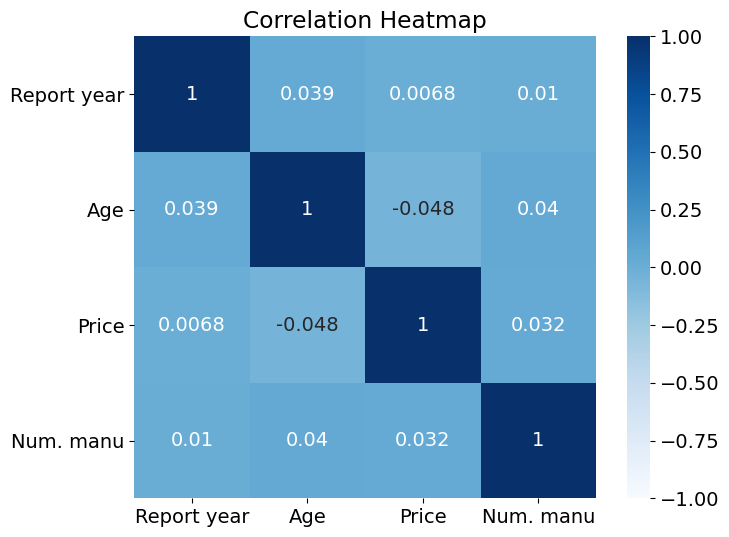

In [44]:
report_year = events_year['year']
age = events['age']
price = prices['unit_price']
num_manu = drugs['manu_num']


num_features = pd.DataFrame({
    'Report year': report_year,
    'Age': age,
    'Price': price,
    'Num. manu': num_manu
})
correlation_matrix = num_features.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, cbar=True, square=True)

plt.yticks(rotation=0)
plt.title('Correlation Heatmap')

plt.show()

In [38]:
num_features = pd.DataFrame({
    'report_year': report_year,
    'age': age,
    'price': price,
    'num_manu': num_manu
})

# Calculate the correlation matrix
correlation_matrix = num_features.corr()

In [ ]:
# matrix

#### Age x. Outcome

#### Prices x. Outcome

#### Number of Manufacturers x. Outcome

### All Text Variables

In [ ]:
# top token - naive bayes processing and/or tf-idf properties by outcome

### All Categorical Variables

#### Sex x. Outcome

#### Expedited Status x. Outcome

#### Report Source x. Outcome

#### Company Making Report x. Outcome

#### Country x. Outcome

#### Product Type x. Outcome

#### Manufacturer x. Outcome